In [58]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool
from utils import estimate_s

In [5]:
def CCC(y_pred, y_true):
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator


In [6]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [5]:
#!wget -O data/10x_2018.zip https://figshare.com/ndownloader/articles/9912734/versions/1

In [6]:
#!unzip data/10x_2018.zip -d data/10x_2018/

In [151]:
rna = ad.read_loom('data/10x_2018_1k/pbmc_10x_1k_fbc.loom')
rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1305 × 64792
    obs: 'bcs', 'obs_names'
    var: 'Accession', 'gid', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

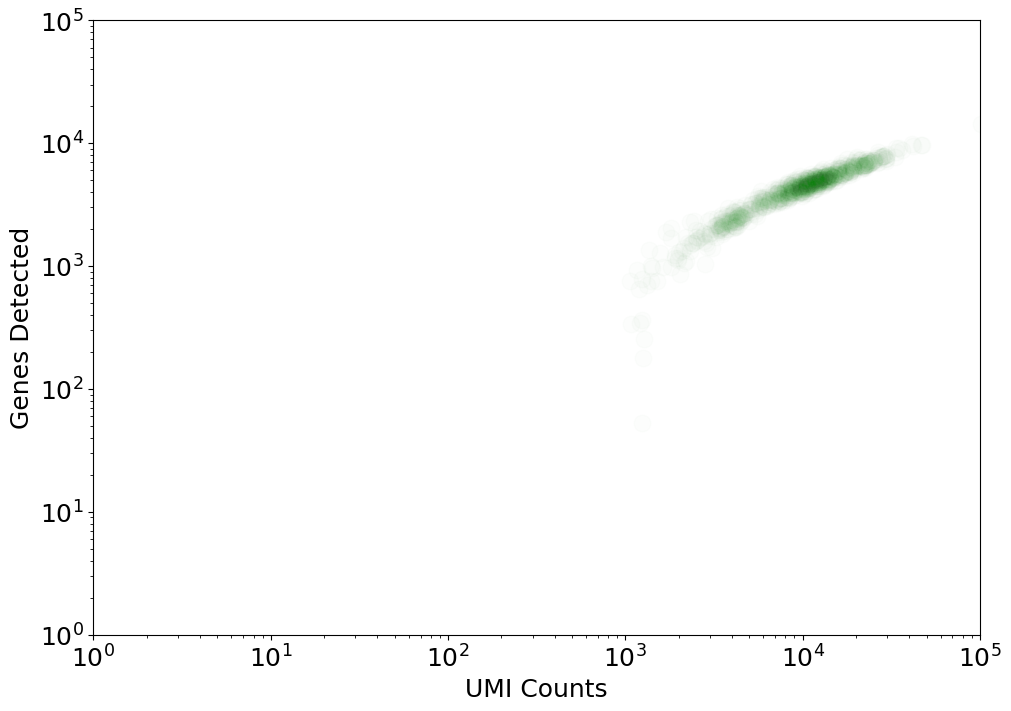

In [155]:
mtx = rna.layers['spliced'].toarray() + rna.layers['unspliced'].toarray() +rna.layers['ambiguous'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1,100000))
ax.set_ylim((1,100000))

plt.show()

In [156]:
rna = rna[mtx.sum(axis=1)>1000]
rna

View of AnnData object with n_obs × n_vars = 708 × 64792
    obs: 'bcs', 'obs_names'
    var: 'Accession', 'gid', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [118]:
import statistics

mtx = rna.layers['spliced'].toarray()+rna.layers['unspliced'].toarray() 
statistics.median(mtx.sum(axis=1))

10316.5

In [119]:
rna.var

,Accession,gid,var_names
Gene,,,
DDX11L1,ENSG00000223972,ENSG00000223972,ENSG00000223972
WASH7P,ENSG00000227232,ENSG00000227232,ENSG00000227232
MIR6859-1,ENSG00000278267,ENSG00000278267,ENSG00000278267
MIR1302-2HG,ENSG00000243485,ENSG00000243485,ENSG00000243485
MIR1302-2,ENSG00000284332,ENSG00000284332,ENSG00000284332
...,...,...,...
RF00002,ENSG00000275757,ENSG00000275757,ENSG00000275757
AC007325.3,ENSG00000278573,ENSG00000278573,ENSG00000278573
AC007325.1,ENSG00000276017,ENSG00000276017,ENSG00000276017


In [157]:
rna.obs

,bcs,obs_names
CellID,,
AAACCCAAGTGGTCAG,AAACCCAAGTGGTCAG,AAACCCAAGTGGTCAG
AAAGGTATCAACTACG,AAAGGTATCAACTACG,AAAGGTATCAACTACG
AAAGTCCAGCGTGTCC,AAAGTCCAGCGTGTCC,AAAGTCCAGCGTGTCC
AACACACTCAAGAGTA,AACACACTCAAGAGTA,AACACACTCAAGAGTA
AACACACTCGACGAGA,AACACACTCGACGAGA,AACACACTCGACGAGA
...,...,...
TTTCGATCAGGCATTT,TTTCGATCAGGCATTT,TTTCGATCAGGCATTT
TTTCGATGTCAACGCC,TTTCGATGTCAACGCC,TTTCGATGTCAACGCC
TTTGACTTCTCCGAGG,TTTGACTTCTCCGAGG,TTTGACTTCTCCGAGG


In [170]:
protein = pd.read_csv('data/10x_2018_1k/pbmc725_4_1k.csv')
protein = protein.T
protein.columns = protein.iloc[0]
protein = protein[1:]
protein = ad.AnnData(protein)
protein

AnnData object with n_obs × n_vars = 713 × 17

In [171]:
protein.obs_names

Index(['AAACCCAAGTGGTCAG', 'AAAGGTATCAACTACG', 'AAAGTCCAGCGTGTCC',
       'AACACACTCAAGAGTA', 'AACACACTCGACGAGA', 'AACAGGGCAGGAGGTT',
       'AACAGGGCAGTGTATC', 'AACAGGGTCAGAATAG', 'AACCTGAAGATGGTCG',
       'AACGGGATCGTTATCT',
       ...
       'TTTCAGTGTGTTAGCT', 'TTTCATGAGAGGGCGA', 'TTTCATGCATCCGGTG',
       'TTTCCTCGTCCCACGA', 'TTTCCTCTCGATTGAC', 'TTTCGATCAGGCATTT',
       'TTTCGATGTCAACGCC', 'TTTGACTTCTCCGAGG', 'TTTGATCCAAACCACT',
       'TTTGGTTCACAAGTGG'],
      dtype='object', length=713)

In [172]:
meta = pd.read_csv('data/10x_2018_1k/pbmc_1k_v3_analysis//clustering/graphclust/clusters.csv')
meta

,Barcode,Cluster
0,AAACCCAAGGAGAGTA-1,5
1,AAACGCTTCAGCCCAG-1,4
2,AAAGAACAGACGACTG-1,7
3,AAAGAACCAATGGCAG-1,6
4,AAAGAACGTCTGCAAT-1,2
...,...,...
1217,TTTCCTCTCTCTTGCG-1,1
1218,TTTGATCTCTTTGGAG-1,6
1219,TTTGGTTAGTAACCTC-1,2
1220,TTTGGTTGTAGAATAC-1,1


In [180]:
meta_bcd = np.array([name[:-2] for name in meta['Barcode']],dtype=str)
meta['bcs'] = meta_bcd
meta

,Barcode,Cluster,bcs
0,AAACCCAAGGAGAGTA-1,5,AAACCCAAGGAGAGTA
1,AAACGCTTCAGCCCAG-1,4,AAACGCTTCAGCCCAG
2,AAAGAACAGACGACTG-1,7,AAAGAACAGACGACTG
3,AAAGAACCAATGGCAG-1,6,AAAGAACCAATGGCAG
4,AAAGAACGTCTGCAAT-1,2,AAAGAACGTCTGCAAT
...,...,...,...
1217,TTTCCTCTCTCTTGCG-1,1,TTTCCTCTCTCTTGCG
1218,TTTGATCTCTTTGGAG-1,6,TTTGATCTCTTTGGAG
1219,TTTGGTTAGTAACCTC-1,2,TTTGGTTAGTAACCTC
1220,TTTGGTTGTAGAATAC-1,1,TTTGGTTGTAGAATAC


In [181]:
meta['bcs'].isin(rna_bcd).sum()

0

In [176]:

rna_bcd = np.array(rna.obs_names,dtype=str)
protein_bcd = np.array(protein.obs_names,dtype=str)

In [177]:
np.intersect1d(np.intersect1d(np.array(rna_bcd),np.array(protein_bcd)),meta_bcd).shape

(0,)

In [149]:
meta_bcd = np.array([name[:-2] for name in meta['Barcode']],dtype=str)
rna_bcd = rna.obs_names
protein_bcd = protein.obs_names
bcd = [ bc for bc in rna_bcd]
common_bc = np.intersect1d(np.intersect1d(bcd,np.array(protein_bcd)),meta_bcd)
print(common_bc.shape)

protein_common_bc_idx = np.array([np.where(np.array(protein_bcd)==bc)[0][0] for bc in common_bc])
rna_common_bc_idx = np.array([np.where(np.array(bcd)==bc)[0][0] for bc in common_bc])

rna = rna[rna_common_bc_idx]
protein = protein[protein_common_bc_idx]

(0,)


IndexError: arrays used as indices must be of integer (or boolean) type

In [124]:
genes = np.array(protein.var_names,dtype=str)
genes

array(['CD3', 'CD4', 'CD8a', 'CD14', 'CD15', 'CD16', 'CD56', 'CD19',
       'CD25', 'CD45RA', 'CD45RO', 'PD-1', 'TIGIT', 'CD127', 'IgG2a',
       'IgG1', 'IgG2b'], dtype='<U6')

In [125]:
rna.var_names[rna.var_names.isin(genes)]

Index(['TIGIT', 'CD14', 'CD4', 'CD19'], dtype='object', name='Gene')

In [126]:
ensg_ids = []
# Example usage
for gene in genes:
    gene_name = gene
    ensg_id = get_ensg_id(gene_name)
    ensg_ids.append(ensg_id)
    if ensg_id:
        print(f"The ENSG ID for gene {gene_name} is: {ensg_id}")
    else:
        print(f"Failed to retrieve ENSG ID for gene {gene_name}")

Failed to retrieve ENSG ID for gene CD3
The ENSG ID for gene CD4 is: ENSG00000010610
The ENSG ID for gene CD8a is: ENSG00000153563
The ENSG ID for gene CD14 is: ENSG00000170458
The ENSG ID for gene CD15 is: ENSG00000196371
The ENSG ID for gene CD16 is: ENSG00000203747
The ENSG ID for gene CD56 is: ENSG00000149294
The ENSG ID for gene CD19 is: ENSG00000177455
The ENSG ID for gene CD25 is: ENSG00000134460
Failed to retrieve ENSG ID for gene CD45RA
Failed to retrieve ENSG ID for gene CD45RO
The ENSG ID for gene PD-1 is: ENSG00000188389
The ENSG ID for gene TIGIT is: ENSG00000181847
The ENSG ID for gene CD127 is: ENSG00000168685
Failed to retrieve ENSG ID for gene IgG2a
Failed to retrieve ENSG ID for gene IgG1
Failed to retrieve ENSG ID for gene IgG2b


In [127]:
ensg_ids[0] = 'ENSG00000167286' #CD3 delta
#ensg_ids[4] = 'ENSG00000081237' #CD45 (PTPRC)
ensg_ids

['ENSG00000167286',
 'ENSG00000010610',
 'ENSG00000153563',
 'ENSG00000170458',
 'ENSG00000196371',
 'ENSG00000203747',
 'ENSG00000149294',
 'ENSG00000177455',
 'ENSG00000134460',
 None,
 None,
 'ENSG00000188389',
 'ENSG00000181847',
 'ENSG00000168685',
 None,
 None,
 None]

In [128]:
protein.var['gid'] = ensg_ids

/tmp/ipykernel_1673221/1234461815.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  protein.var['gid'] = ensg_ids


In [129]:
common_genes = protein.var['gid'][protein.var['gid'].isin(rna.var['gid'])]
rna_gene_idx = np.array([ np.where(np.array(rna.var['gid']) == ensg_id)[0][0] for ensg_id in common_genes])
protein_gene_idx = np.array([ np.where(np.array(protein.var['gid']) == ensg_id)[0][0] for ensg_id in common_genes])

In [130]:
protein_gene_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13])

In [131]:
adata = rna

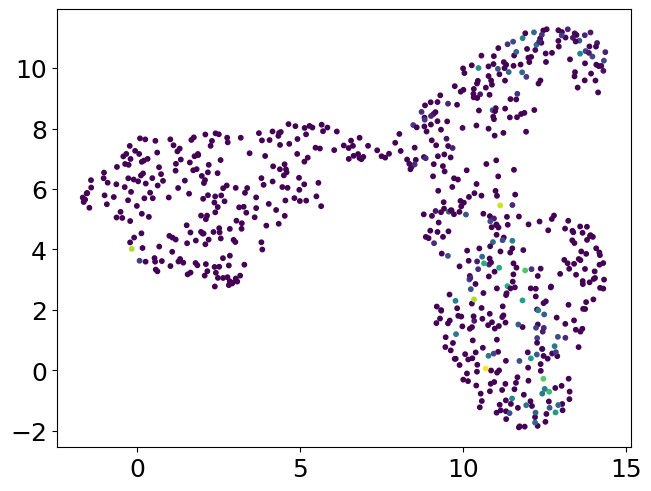

In [135]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=protein.X[:,2],s=10)

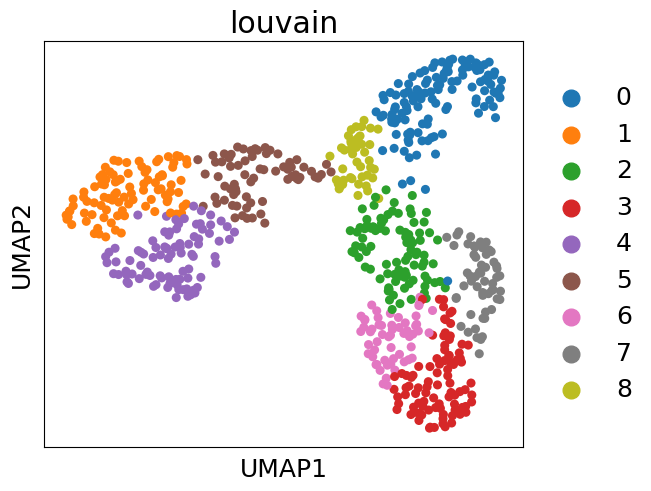

In [136]:
sc.tl.louvain(adata)
sc.pl.umap(adata,color=['louvain'])

## Select one cluster

In [137]:
adata = adata[adata.obs['louvain']=='0']
adata

View of AnnData object with n_obs × n_vars = 120 × 64792
    obs: 'bcs', 'obs_names', 'louvain'
    var: 'Accession', 'gid', 'var_names'
    uns: 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

0.0434341 0.021942653


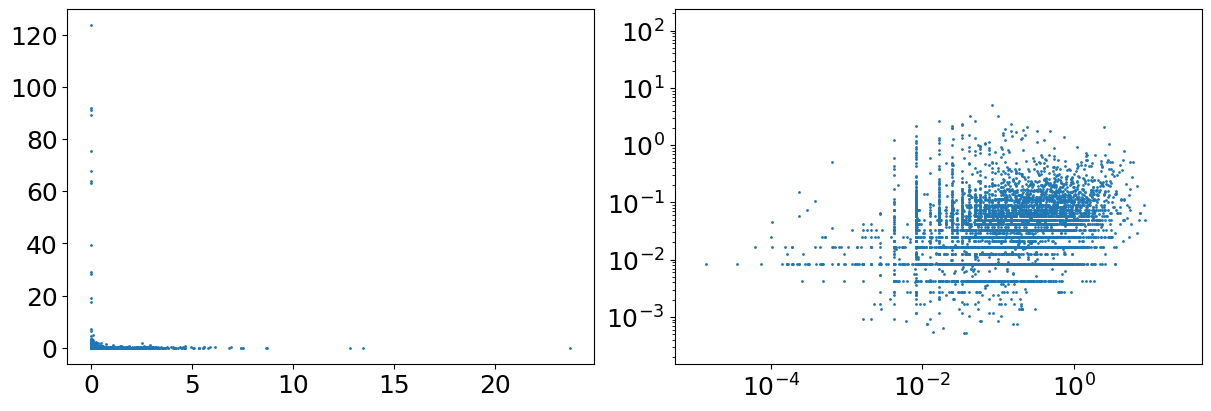

In [138]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

## Calculate CV$^2$ of read depth

s estimated by total counts = 0.2889407615871823
1669 su= 0.26781040155672536
3510 ss= 0.5568491483152088
1444 s= 0.3193007919363492


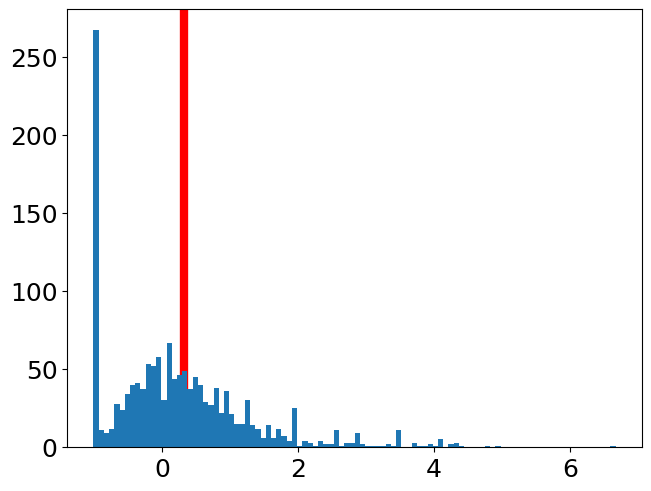

In [139]:
su, ss, sp = estimate_s(adata)

In [140]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(271078.25, 57541.75)

Text(0.02, 0.5, 'CV$^2$')

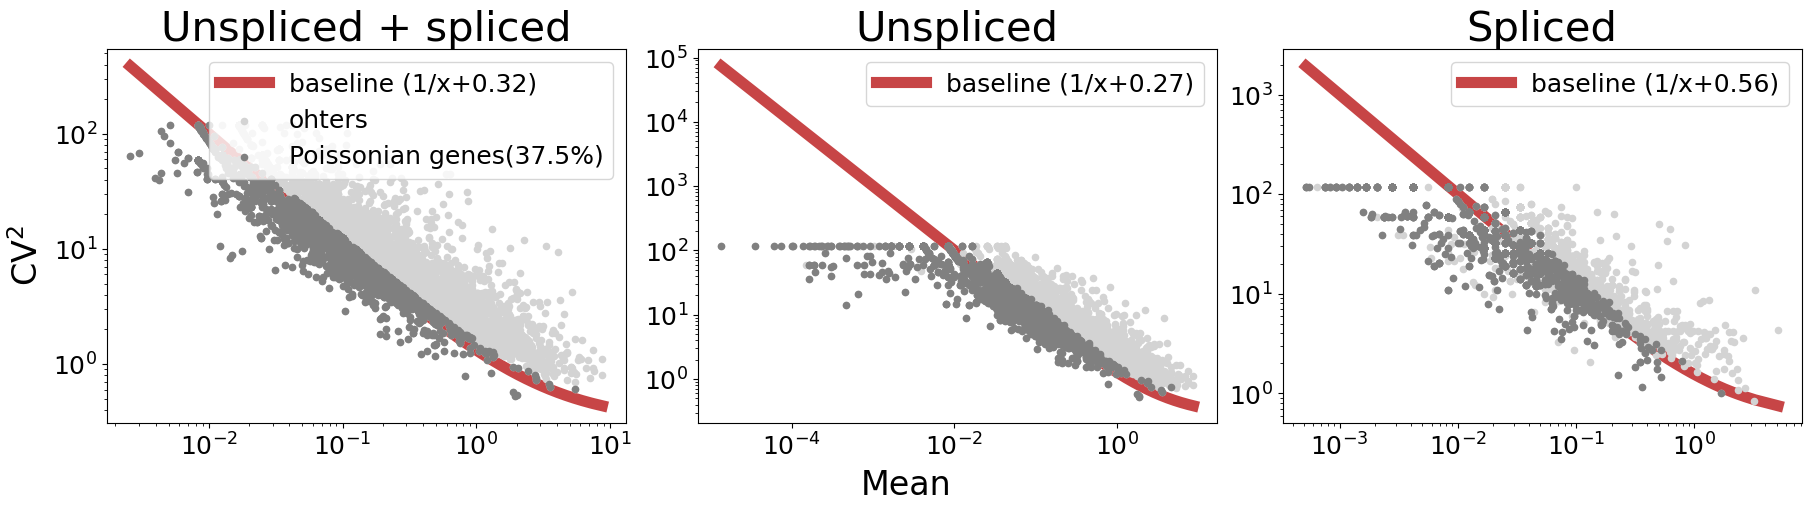

In [141]:
X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

Text(0, 0.5, 'Using total counts')

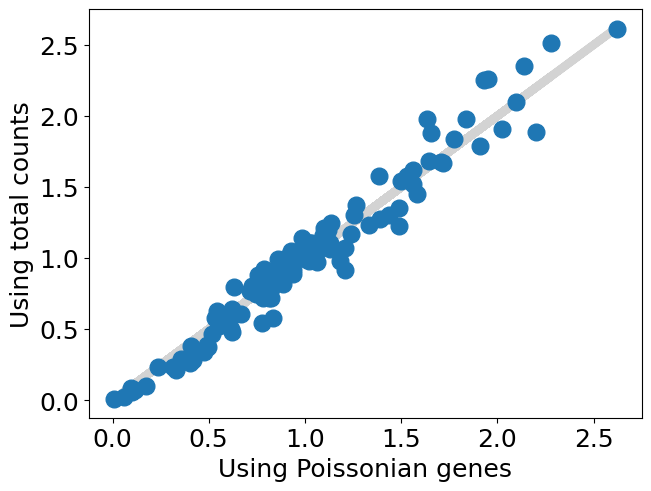

In [145]:
rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(rd,rd_)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)

s estimated by total counts = 0.1557664066364793
1166 su= 0.17424445025736723
1473 ss= 0.17511490270999783
2640 s= 0.16335358361891347


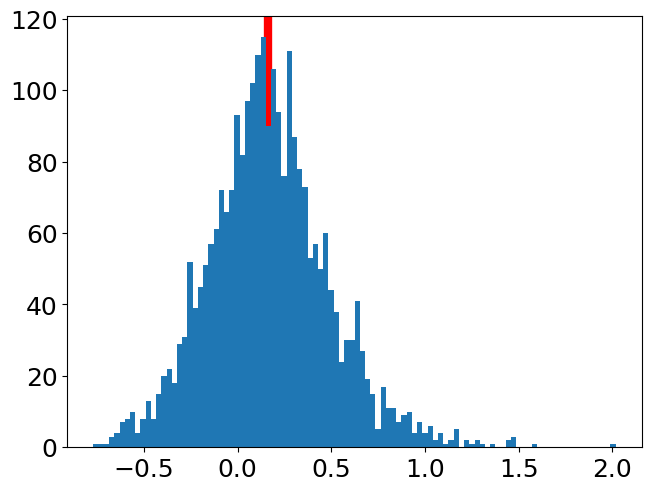

In [47]:
su, ss, sp = estimate_s(adata)

/tmp/ipykernel_1669695/3504455114.py:12: RuntimeWarning: invalid value encountered in divide
  Pgene_mask = (U_mean >0.1) & (S_mean >0.1) & (X_var/(X_mean + sp*X_mean**2) < 1.2)
/tmp/ipykernel_1669695/3504455114.py:15: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
/tmp/ipykernel_1669695/3504455114.py:16: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
/tmp/ipykernel_1669695/3504455114.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
/tmp/ipykernel_1669695/3504455114.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
/tmp/ipyk

Text(0.02, 0.5, 'CV$^2$')

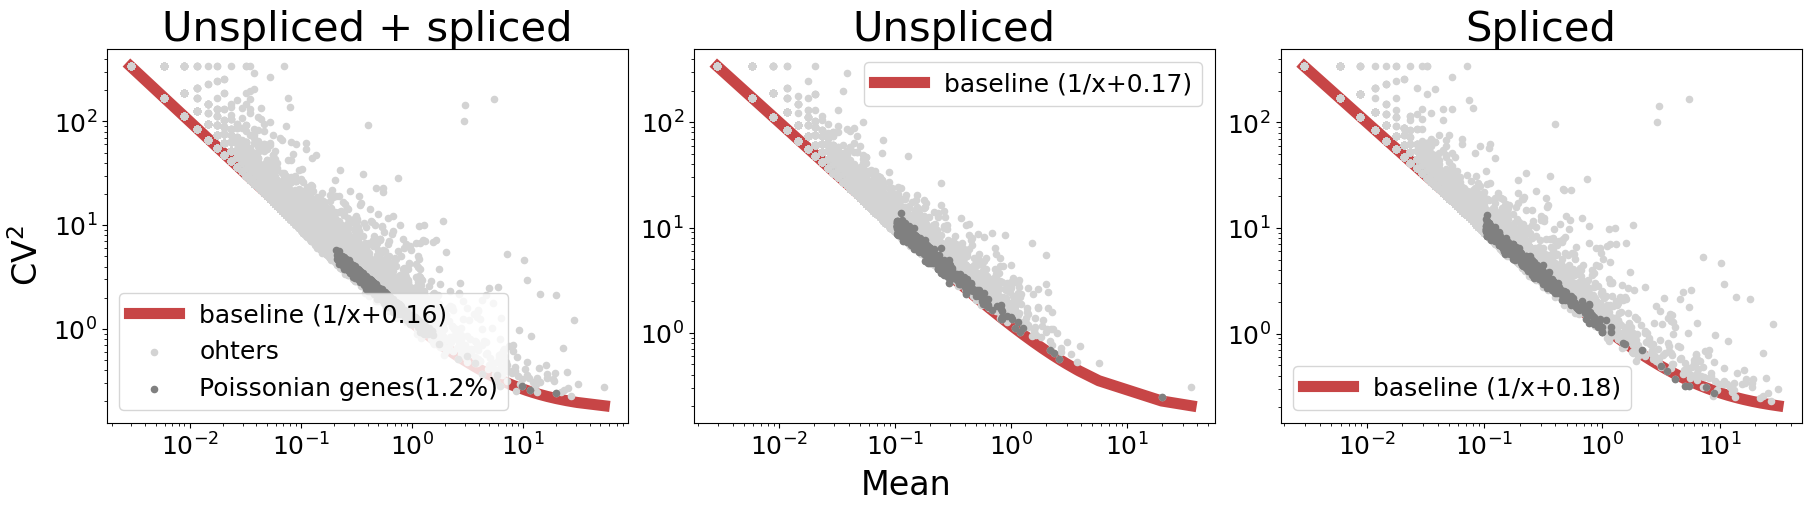

In [48]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (U_mean >0.1) & (S_mean >0.1) & (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

/tmp/ipykernel_1669695/3532842269.py:12: RuntimeWarning: invalid value encountered in divide
  Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)
/tmp/ipykernel_1669695/3532842269.py:16: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(X_mean, X_var/X_mean-sp*X_mean,c='lightgray',alpha=1, s=20)
/tmp/ipykernel_1669695/3532842269.py:22: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
/tmp/ipykernel_1669695/3532842269.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]-sp*U_mean[Pgene_mask], s=20, c='gray')
/tmp/ipykernel_1669695/3532842269.py:28: RuntimeWarning: invalid value encountered in divide
  ax[2].scatter(S_mean, S_var/S_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
/tmp/ipykernel_1669695/3532842269.py:29: RuntimeWarning: invalid value encountered in divide
  ax[2]

Text(0.02, 0.5, 'CV$^2$')

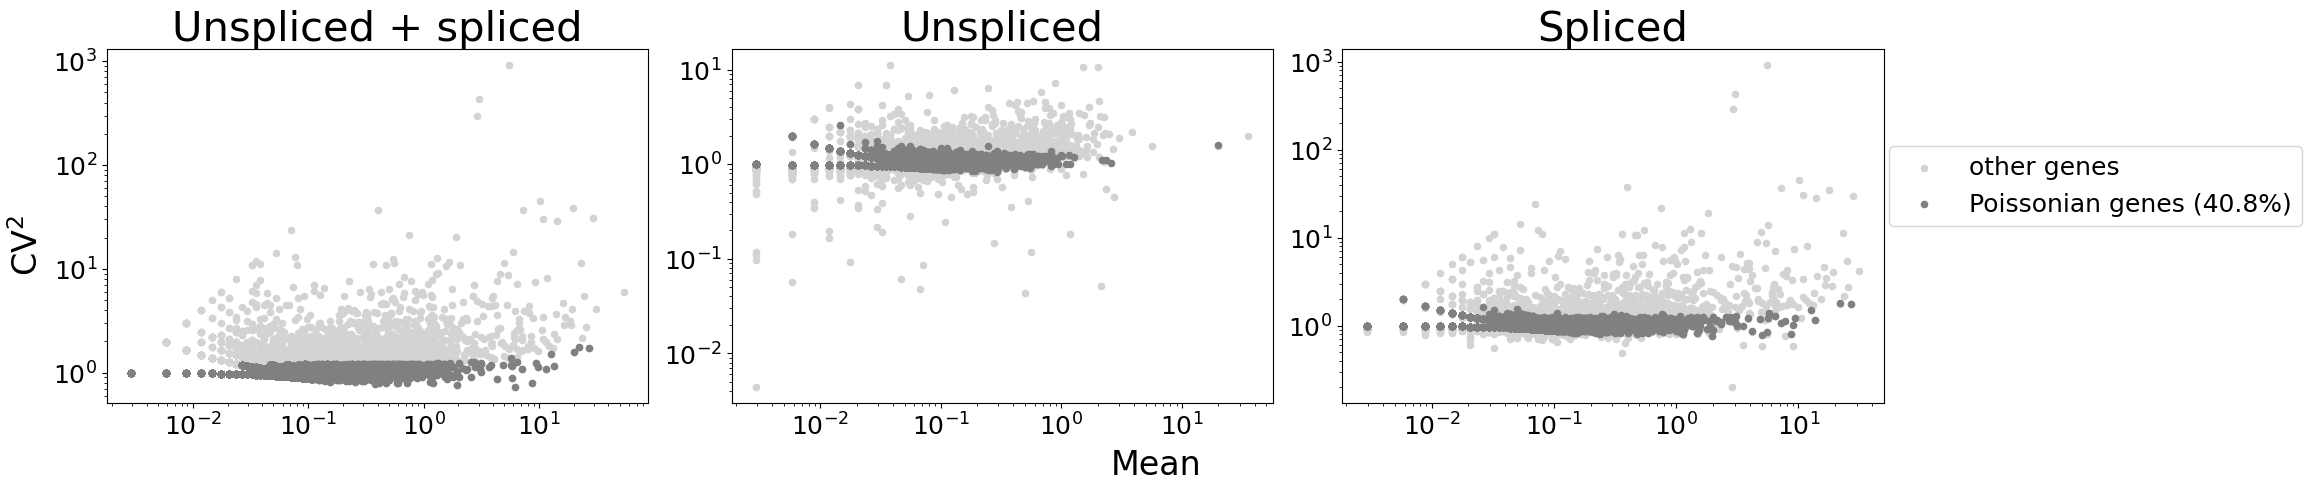

In [49]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2) 

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].scatter(X_mean, X_var/X_mean-sp*X_mean,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask], s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].scatter(U_mean, U_var/U_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]-sp*U_mean[Pgene_mask], s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].scatter(S_mean, S_var/S_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]-sp*S_mean[Pgene_mask], s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

0.40781741556360185


/tmp/ipykernel_1669695/2162023319.py:6: RuntimeWarning: invalid value encountered in divide
  return var/mean-s*mean-1


Text(0.5, 1.0, 'U+S+A')

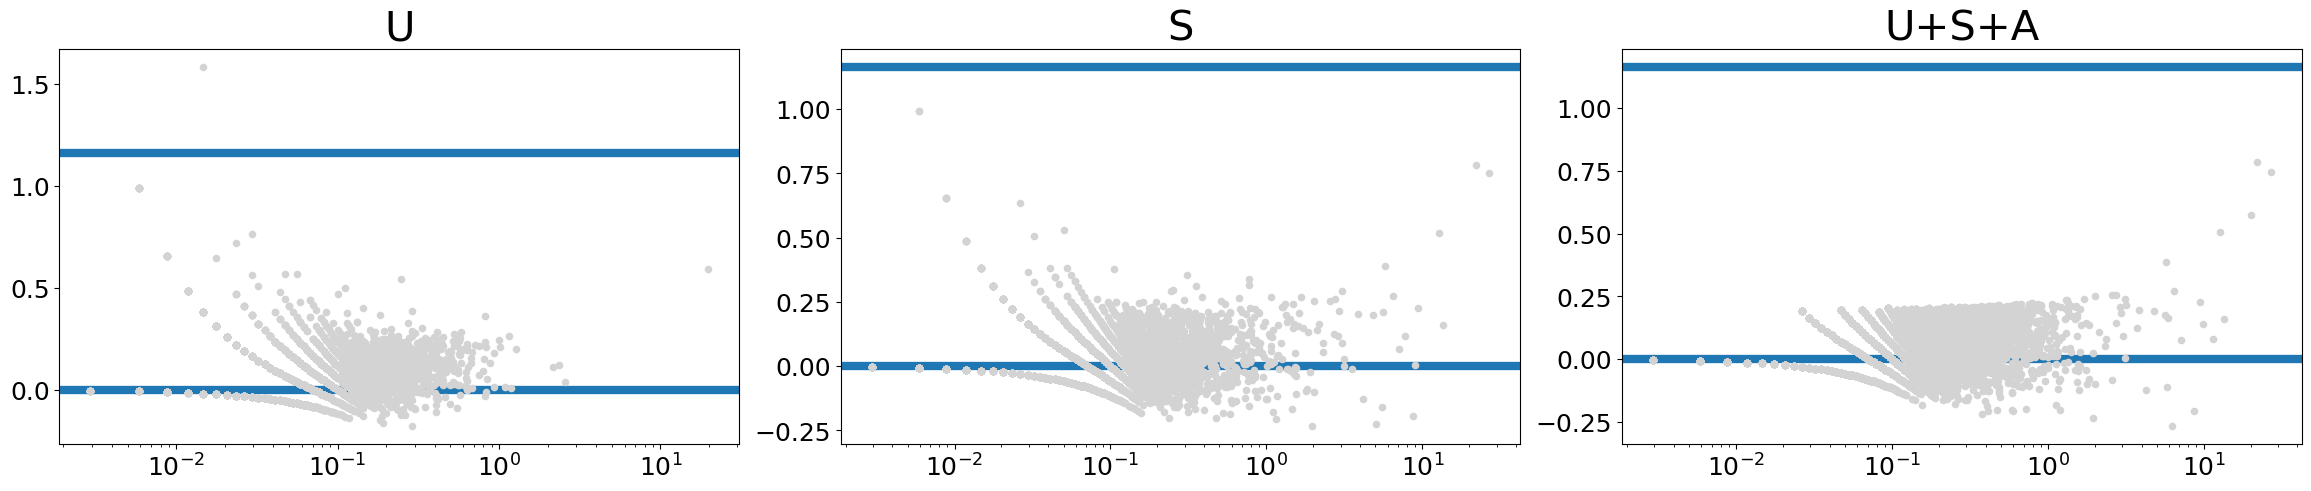

In [50]:
print(Pgene_mask.mean())
s=sp
def f(X):
    mean = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    return var/mean-s*mean-1

fig, ax = plt.subplots(1,3,figsize=(23,4.8))
ax[0].scatter(U_mean[Pgene_mask], f(U[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[0].axhline(y=0,zorder=0)
ax[0].axhline(y=1+s,zorder=0)
ax[0].set_xscale('log')
ax[0].set_title('U',fontsize=title_font)

ax[1].scatter(S_mean[Pgene_mask], f(S[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[1].axhline(y=0,zorder=0)
ax[1].axhline(y=1+s,zorder=0)
ax[1].set_xscale('log')
ax[1].set_title('S',fontsize=title_font)

X_ = S + U 
ax[2].scatter(X_mean[Pgene_mask], f(X_[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[2].axhline(y=0,zorder=0)
ax[2].axhline(y=1+s,zorder=0)
ax[2].set_xscale('log')
ax[2].set_title('U+S+A',fontsize=title_font)

(array([144., 115.,  48.,  14.,   9.,   4.,   0.,   3.,   0.,   3.]),
 array([ 1762. ,  2668.8,  3575.6,  4482.4,  5389.2,  6296. ,  7202.8,
         8109.6,  9016.4,  9923.2, 10830. ]),
 <BarContainer object of 10 artists>)

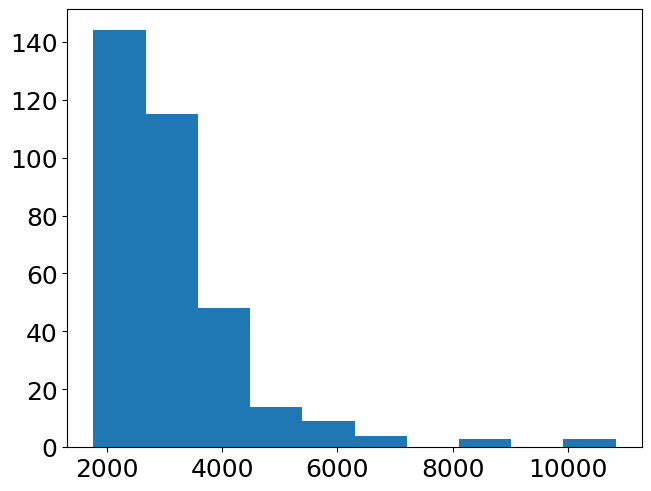

In [51]:
plt.hist(X.sum(1))

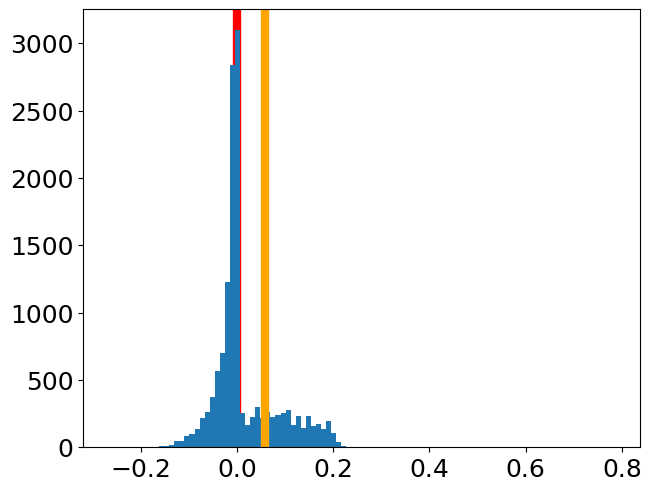

In [52]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+s),c='orange')

# Check covariance relationships

In [98]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.1) & (adata.layers["unspliced"].toarray().mean(0) > 0.1)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(633,)

## Var(N_U)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


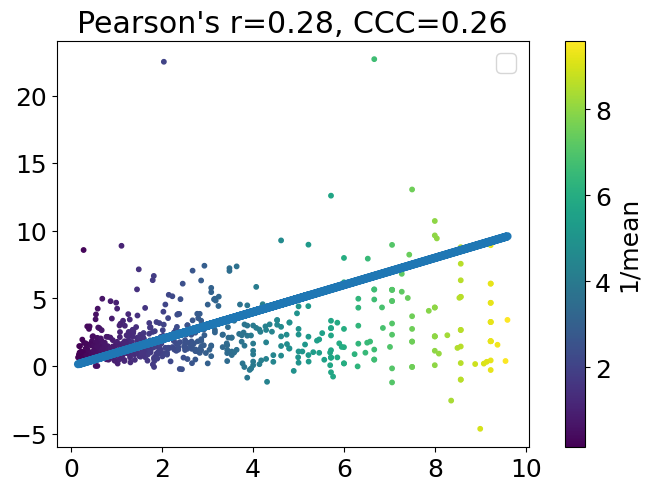

In [99]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=x)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

Text(0.5, 1.0, '96.68% of cells >= 0')

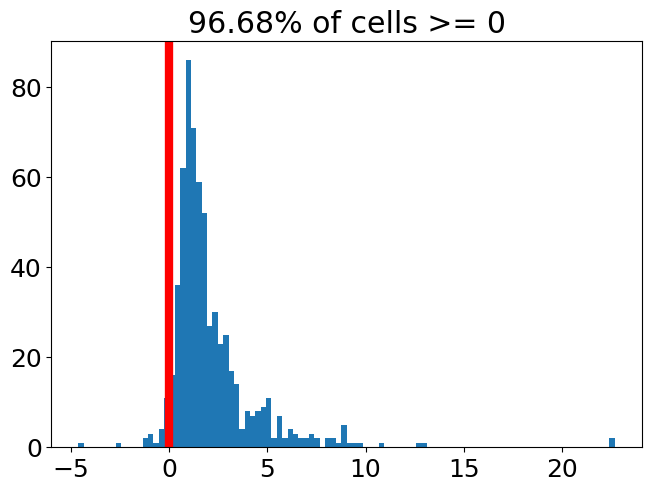

In [100]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

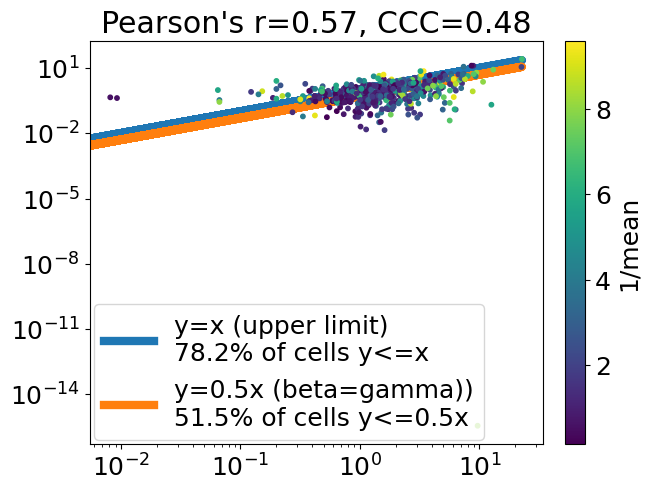

In [101]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

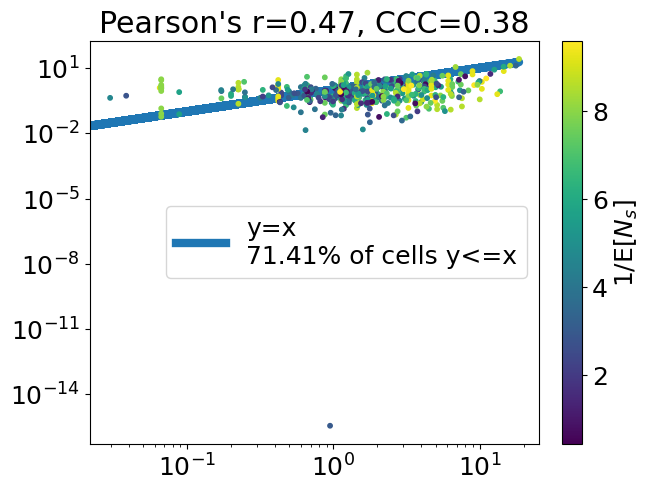

In [102]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# Check protein varaince

In [103]:
U = adata.layers["unspliced"].toarray()[:,gene_idx]
S = adata.layers["spliced"].toarray()[:,gene_idx]
P = np.array(protein.X.toarray()[cluster_idx],dtype=int)
P.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.

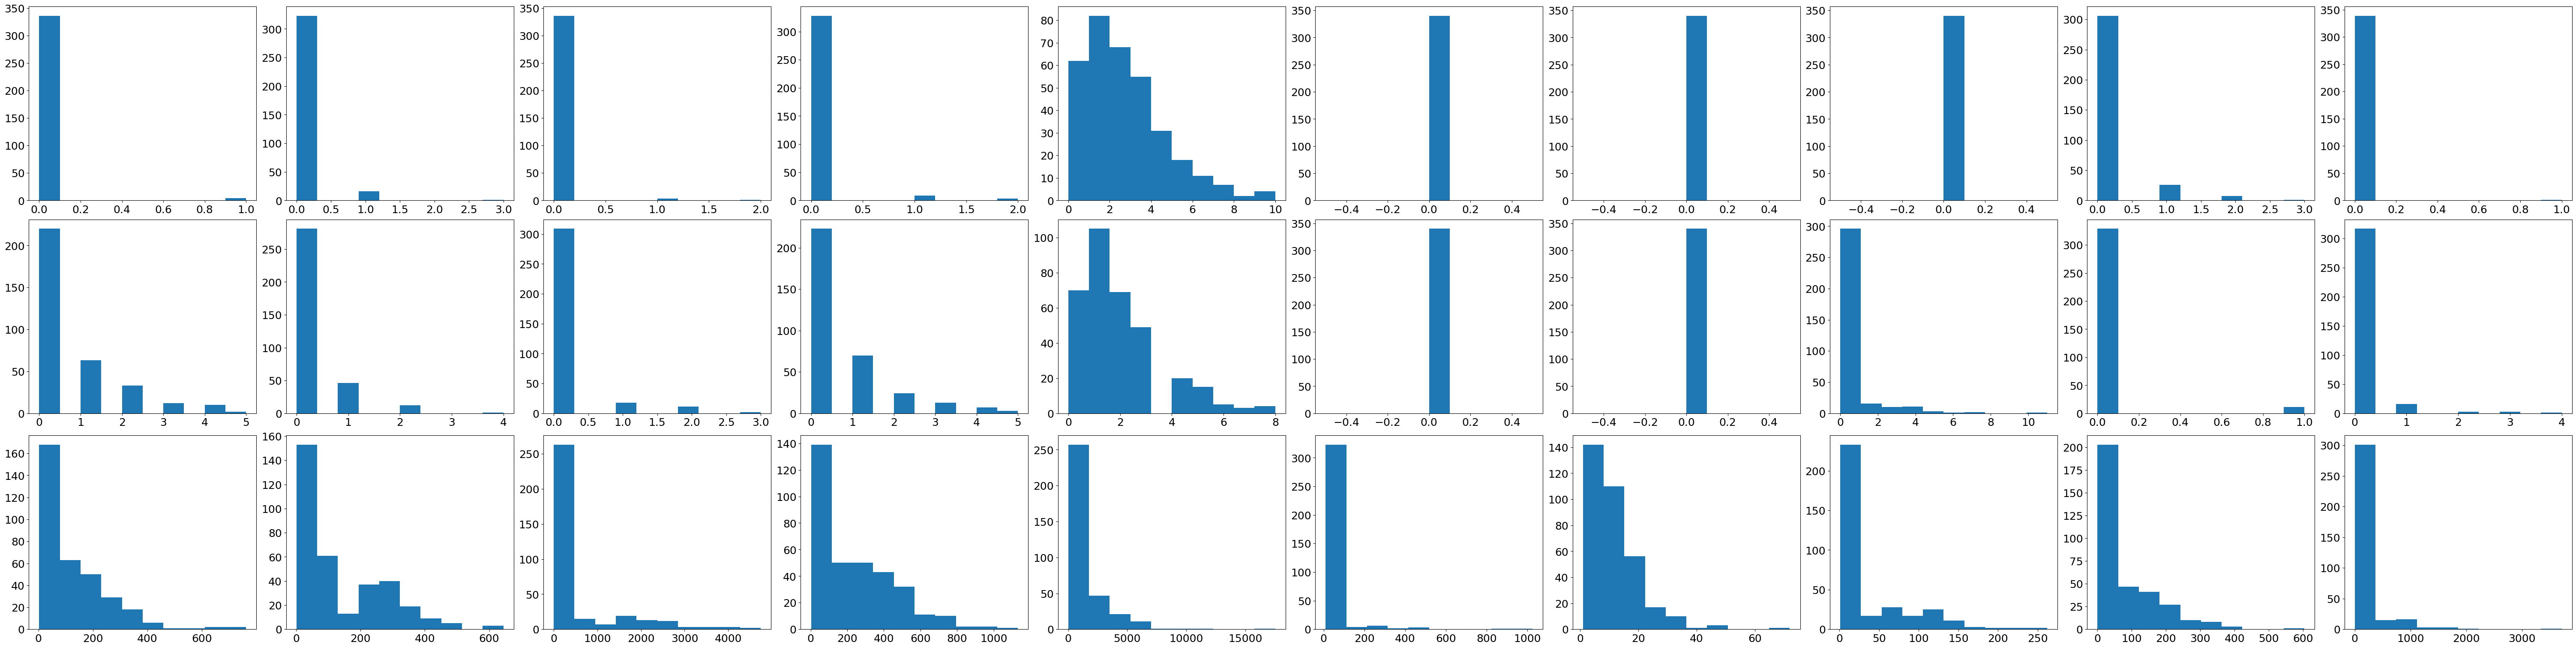

In [59]:
fig,ax = plt.subplots(3,10,figsize=(60,15))
for i in range(10):
    ax[0,i].hist(U[:,i])
    ax[1,i].hist(S[:,i])
    ax[2,i].hist(P[:,i])

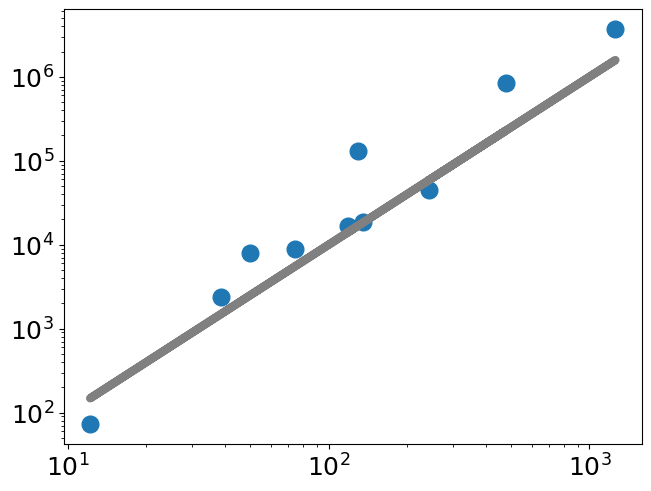

In [60]:
plt.scatter(P.mean(0),P.var(0))
plt.loglog(P.mean(0),P.mean(0)**2,'gray')

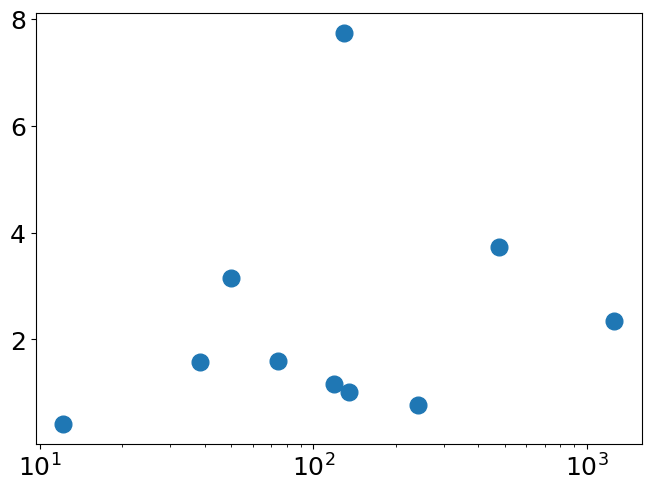

In [61]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.xscale('log')

In [62]:
iidx = (np.mean(U,axis=0)>0.01) &  (np.mean(S,axis=0)>0) &  (np.mean(P,axis=0)>0)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)
zeta_us

array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
        2.60173249])

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [63]:
zeta_up,zeta_us

(array([1.23711101, 1.01301436, 3.68821146, 0.97593109, 0.20403315,
        0.98604154]),
 array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
         2.60173249]))

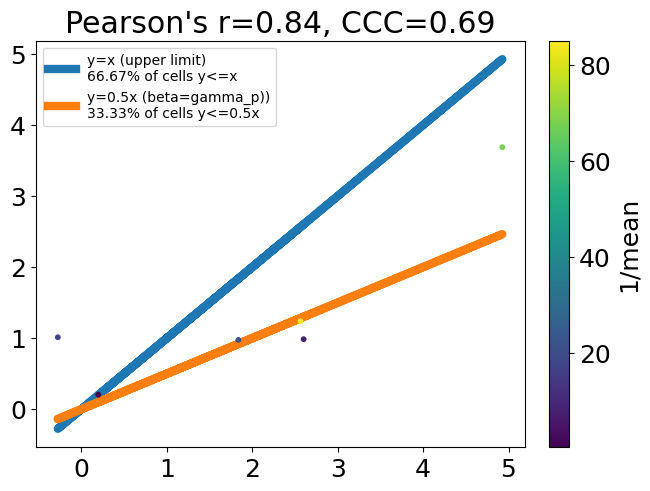

In [64]:
x=zeta_us
y=zeta_up

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma_p))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(fontsize=10)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [65]:
zeta_up-zeta_sp,(zeta_up-zeta_sp)/(zeta_ss-zeta_sp)

(array([ 0.45357414,  0.65412781,  1.03778763,  0.33179173,  0.19208809,
        -0.38086888]),
 array([1.11074676, 0.74644718, 0.57250484, 0.50977384, 0.74721531,
        0.16091394]))

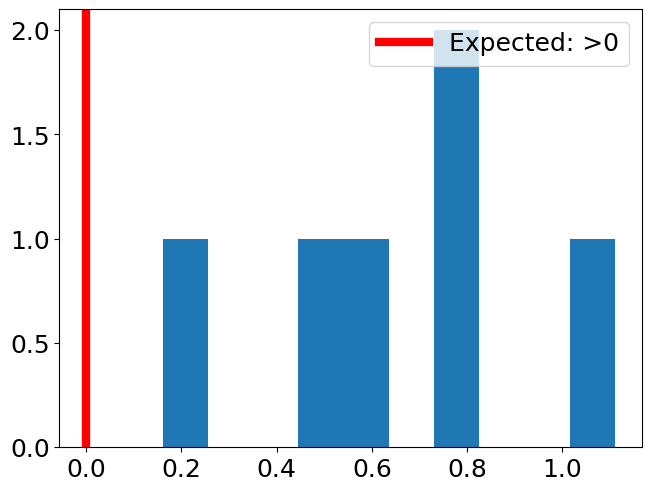

In [66]:
plt.hist((zeta_up-zeta_sp)/(zeta_ss-zeta_sp));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.legend()

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

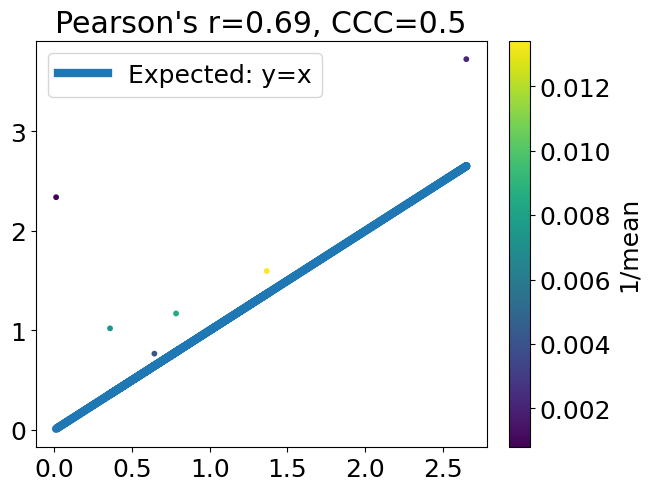

In [67]:
x=zeta_sp
y=zeta_pp

plt.plot(x,x,zorder=0,label='Expected: y=x')
plt.scatter(x,y,s=10,alpha=1,c=1/P_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()